# **Modelo Supervisado Con Imágenes**

**Objetivo General:**

Desarrollar un prototipo de clasificación automática de residuos reciclables mediante deep learning para gestión ambiental en el Caribe colombiano.


**Objetivos Específicos:**
1. Formular el problema como clasificación supervisada multiclase (6 categorías)

2. Analizar dataset de 2,527 imágenes evaluando distribución y sesgos
3. Implementar preprocesamiento con normalización, redimensionamiento y data augmentation
4. Diseñar arquitectura CNN con transfer learning (MobileNetV2)
5. Entrenar modelo con técnicas de regularización y optimización
6. Evaluar rendimiento mediante accuracy, precision, recall, F1-score y matriz de confusión
7. Identificar limitaciones: desbalance, sobreajuste y confusiones entre clases
8. Proponer mejoras: ampliación de datos, fine-tuning y ensemble methods

**Stack del Notebook:**

[![techs](https://skills.syvixor.com/api/icons?i=googlecolaboratory,python,tensorflow&perline=8&radius=40)](https://github.com/syvixor/skills-icons)

> Made with '\u{2665}' (♥) by Jesús Domínguez [@bluefeatherdev](https://github.com/bluefeatherdev)

## **1. Introducción y Contexto**

### **Problema**

Identificar automáticamente tipos de residuos en playas para apoyar campañas de limpieza

### **Clases**

1. Plástico

1. Vidrio
1. Metal
1. Papel/Cartón
1. Orgánico
1. No-reciclable

### **Justificación**

Santa Marta y la costa Caribe enfrentan problemas de contaminación marina. Un sistema automatizado puede ayudar a voluntarios y empresas de limpieza a clasificar residuos eficientemente

## **2. Importación de Librerías**

In [ ]:
# 1.1 Montar Google Drive (para guardar el modelo)
from google.colab import drive
drive.mount('/content/drive')

# 1.2 Instalar librerías necesarias
!pip install kaggle split-folders

# 1.3 Importar librerías
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **3. Carga y Exploración del Dataset**

### **Obtener dataset con Kaggle**

In [ ]:
# 2.1 Subir tu archivo kaggle.json (credenciales de Kaggle)
from google.colab import files
files.upload()  # Sube kaggle.json

# 2.2 Configurar Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 2.3 Descargar dataset
!kaggle datasets download -d asdasdasasdas/garbage-classification
!unzip garbage-classification.zip -d dataset

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: dataset/Garbage classification/Garbage classification/cardboard

### **Verificar dataset cargado**

In [ ]:
# Listar contenido de la carpeta dataset
print("Contenido de /content/dataset:")
for item in os.listdir('/content/dataset'):
    print(f"  📁 {item}")

# Ver la estructura completa
!ls -R /content/dataset | head -50

Contenido de /content/dataset:
  📁 one-indexed-files-notrash_val.txt
  📁 zero-indexed-files.txt
  📁 Garbage classification
  📁 one-indexed-files-notrash_test.txt
  📁 garbage classification
  📁 one-indexed-files-notrash_train.txt
  📁 one-indexed-files.txt
/content/dataset:
garbage classification
Garbage classification
one-indexed-files-notrash_test.txt
one-indexed-files-notrash_train.txt
one-indexed-files-notrash_val.txt
one-indexed-files.txt
zero-indexed-files.txt

/content/dataset/garbage classification:
Garbage classification

/content/dataset/garbage classification/Garbage classification:
cardboard
glass
metal
paper
plastic
trash

/content/dataset/garbage classification/Garbage classification/cardboard:
cardboard100.jpg
cardboard101.jpg
cardboard102.jpg
cardboard103.jpg
cardboard104.jpg
cardboard105.jpg
cardboard106.jpg
cardboard107.jpg
cardboard108.jpg
cardboard109.jpg
cardboard10.jpg
cardboard110.jpg
cardboard111.jpg
cardboard112.jpg
cardboard113.jpg
cardboard114.jpg
cardboard115.

### **Exploración del dataset**




Clases encontradas: ['metal', 'plastic', 'trash', 'glass', 'paper', 'cardboard']
metal: 410 imágenes
plastic: 482 imágenes
trash: 137 imágenes
glass: 501 imágenes
paper: 594 imágenes
cardboard: 403 imágenes


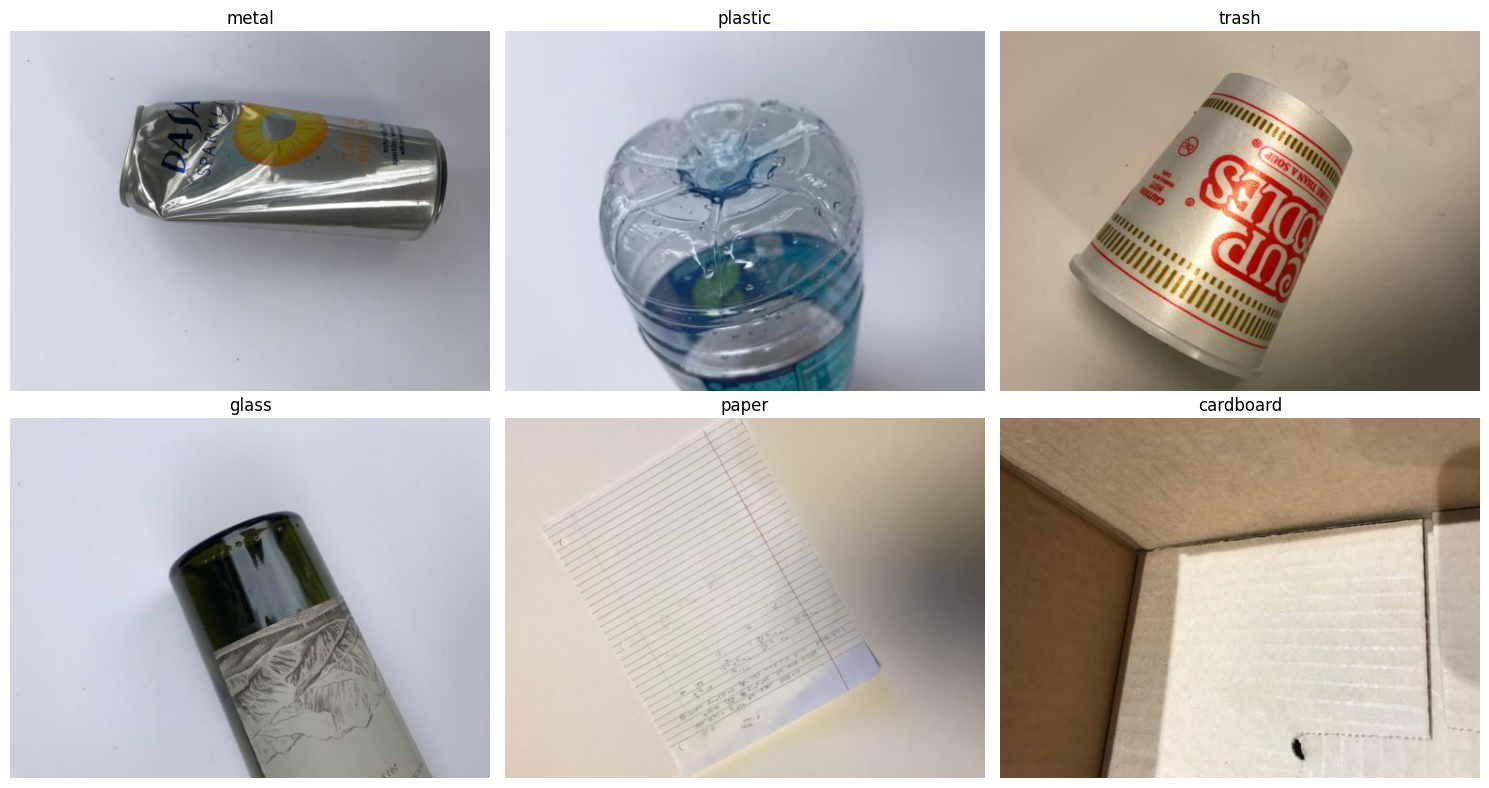

In [ ]:
# 3.1 Explorar estructura
dataset_path = '/content/dataset/Garbage classification/Garbage classification'
classes = os.listdir(dataset_path)
print(f"Clases encontradas: {classes}")

# 3.2 Contar imágenes por clase
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"{class_name}: {num_images} imágenes")

# 3.3 Visualizar ejemplos
plt.figure(figsize=(15, 8))
for i, class_name in enumerate(classes[:6]):
    class_path = os.path.join(dataset_path, class_name)
    img_file = random.choice(os.listdir(class_path))
    img = plt.imread(os.path.join(class_path, img_file))
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

## **4. Preprocesamiento de Datos**

In [ ]:
# 4.1 Dividir dataset (70% train, 15% val, 15% test)
import splitfolders
splitfolders.ratio(dataset_path, output="dataset_split",
                   seed=42, ratio=(.7, .15, .15))

# 4.2 Configurar generadores de datos con Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset_split/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'dataset_split/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'dataset_split/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Copying files: 2527 files [00:00, 3710.91 files/s]


Found 1766 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Found 384 images belonging to 6 classes.


## **5. Construcción del Modelo**

In [ ]:
# 5.1 Modelo usando MobileNetV2 (eficiente y preciso)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Congelar capas preentrenadas

# 5.2 Construir modelo completo
num_classes = len(classes)

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# 5.3 Compilar
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **6. Entrenamiento**

In [ ]:
# 6.1 Callbacks para guardar mejor modelo
checkpoint = keras.callbacks.ModelCheckpoint(
    'mejor_modelo.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 6.2 Entrenar
EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4349 - loss: 1.5480
Epoch 1: val_accuracy improved from -inf to 0.77188, saving model to mejor_modelo.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.4370 - loss: 1.5418 - val_accuracy: 0.7719 - val_loss: 0.6453
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7120 - loss: 0.7772
Epoch 2: val_accuracy improved from 0.77188 to 0.79045, saving model to mejor_modelo.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.7121 - loss: 0.7767 - val_accuracy: 0.7905 - val_loss: 0.5576
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7625 - loss: 0.6553
Epoch 3: val_accuracy improved from 0.79045 to 0.82759, saving model to mejor_modelo.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7623 - loss: 0.6557 - val_accuracy: 0.8276 - val_loss: 0.5122
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7882 - loss: 0.5820
Epoch 4: val_accuracy did not improve from 0.82759
56/56 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7880 - loss: 0.5820 - val_accuracy: 0.8249 - val_loss: 0.5216
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7914 - loss: 0.5577
Epoch 5: val_accuracy did not improve from 0.82759
56/56 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7914 - loss: 0.5579 - val_accuracy: 0.8170 - val_loss: 0.5139
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8100 - loss: 0.5008
Epoch 6: val_accuracy did not improve from 0.82759
56/56 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8100 - loss: 0.5010 - val_accuracy: 0.8276 - val_loss: 0.5025
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8416 - loss: 0.4345
Epoch 7: val_accuracy did not improve from 0.82759


56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8293 - loss: 0.4658 - val_accuracy: 0.8382 - val_loss: 0.4482
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8203 - loss: 0.4441
Epoch 9: val_accuracy improved from 0.83820 to 0.85411, saving model to mejor_modelo.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8203 - loss: 0.4442 - val_accuracy: 0.8541 - val_loss: 0.4238
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8732 - loss: 0.3533
Epoch 10: val_accuracy improved from 0.85411 to 0.86472, saving model to mejor_modelo.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8729 - loss: 0.3538 - val_accuracy: 0.8647 - val_loss: 0.4347
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8514 - loss: 0.4167
Epoch 11: val_accuracy did not improve from 0.86472
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8514 - loss: 0.4165 - val_accuracy: 0.8329 - val_loss: 0.4897
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8662 - loss: 0.3468
Epoch 12: val_accuracy did not improve from 0.86472
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8661 - loss: 0.3470 - val_accuracy: 0.8515 - val_loss: 0.4232
Epoch 13/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8479 - loss: 0.3737
Epoch 13: val_accuracy did not improve from 0.86472
56/56 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8480 - loss: 0.3737 - val_accuracy: 0.8462 - val_loss: 0.4437
Epoch 14/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8842 - loss: 0.3337
Epoch 14: val_accuracy improved from 0.86472

56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8840 - loss: 0.3340 - val_accuracy: 0.8674 - val_loss: 0.4169
Epoch 15/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8621 - loss: 0.3706
Epoch 15: val_accuracy did not improve from 0.86737
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8622 - loss: 0.3705 - val_accuracy: 0.8594 - val_loss: 0.4324
Epoch 16/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8802 - loss: 0.3052
Epoch 16: val_accuracy improved from 0.86737 to 0.87533, saving model to mejor_modelo.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.8802 - loss: 0.3054 - val_accuracy: 0.8753 - val_loss: 0.4096
Epoch 17/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8898 - loss: 0.3082
Epoch 17: val_accuracy did not improve from 0.87533
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8896 - loss: 0.3083 - val_accuracy: 0.8700 - val_loss: 0.3944
Epoch 18/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8933 - loss: 0.2752
Epoch 18: val_accuracy did not improve from 0.87533
56/56 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8932 - loss: 0.2757 - val_accuracy: 0.8674 - val_loss: 0.4022
Epoch 19/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8972 - loss: 0.2940
Epoch 19: val_accuracy improved from 0.87533 to 0.87798, saving model to mejor_modelo.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8971 - loss: 0.2941 - val_accuracy: 0.8780 - val_loss: 0.4196
Epoch 20/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8854 - loss: 0.2849
Epoch 20: val_accuracy did not improve from 0.87798
56/56 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8857 - loss: 0.2849 - val_accuracy: 0.8621 - val_loss: 0.4504


## **7. Evaluación y Métricas**

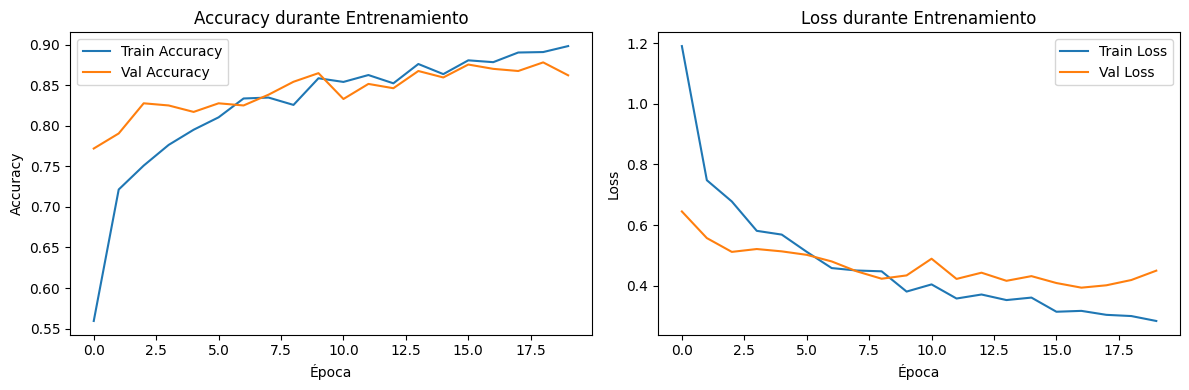

12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8524 - loss: 0.5343

Accuracy en Test: 84.90%
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


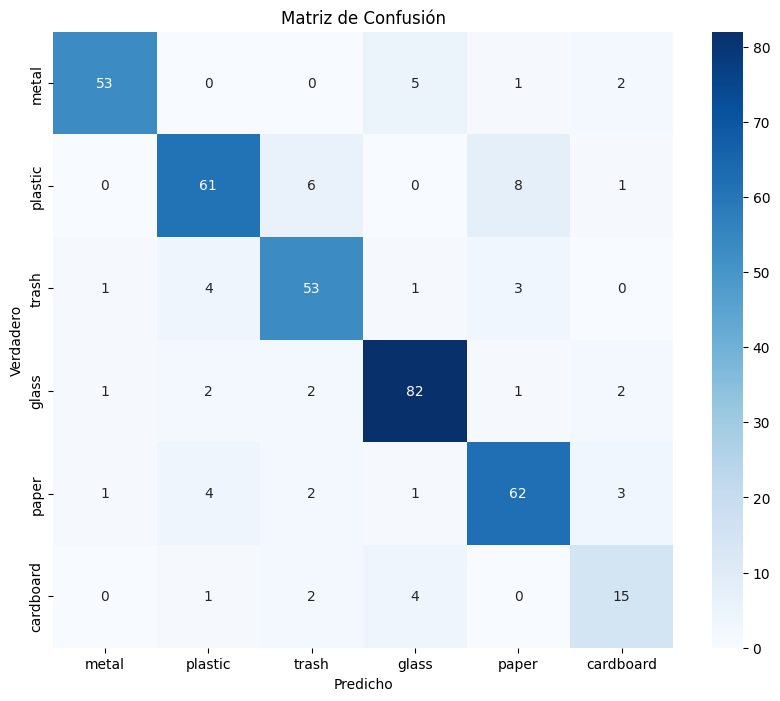


Reporte de Clasificación:
              precision    recall  f1-score   support

       metal       0.95      0.87      0.91        61
     plastic       0.85      0.80      0.82        76
       trash       0.82      0.85      0.83        62
       glass       0.88      0.91      0.90        90
       paper       0.83      0.85      0.84        73
   cardboard       0.65      0.68      0.67        22

    accuracy                           0.85       384
   macro avg       0.83      0.83      0.83       384
weighted avg       0.85      0.85      0.85       384



In [ ]:
# 7.1 Gráficas de entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy durante Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss durante Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 7.2 Evaluación en test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nAccuracy en Test: {test_accuracy*100:.2f}%")

# 7.3 Predicciones
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# 7.4 Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

# 7.5 Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=classes))

## **8. Análisis de errores**

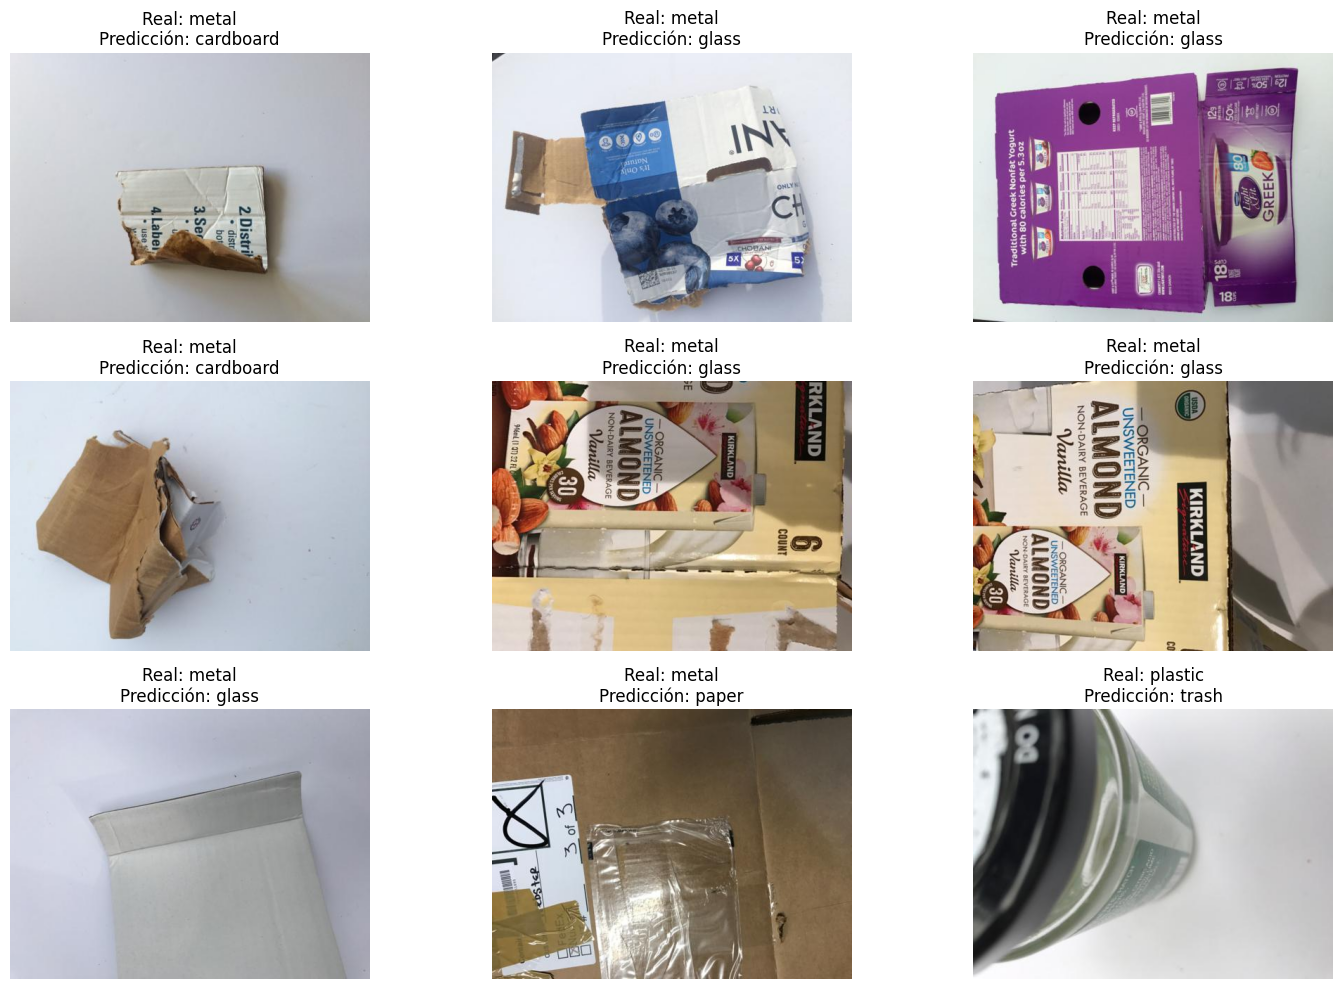

In [ ]:
# Encontrar imágenes mal clasificadas
misclassified_idx = np.where(y_pred != y_true)[0]

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx[:9]):
    plt.subplot(3, 3, i+1)
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)
    plt.imshow(img)
    true_class = classes[y_true[idx]]
    pred_class = classes[y_pred[idx]]
    plt.title(f"Real: {true_class}\nPredicción: {pred_class}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## **9. Conclusiones**

1. El modelo de clasificación de imágenes, que utiliza una arquitectura  MobileNetV2 pre-entrenada con una capa clasificadora personalizada, ha logrado una aceptable precisión del 84.90% en el conjunto de prueba.

1. Al analizar el reporte de clasificación y la matriz de confusión, se observa una variabilidad en el rendimiento entre las clases.

1. Las clases 'cardboard' (cartón), 'plastic' (plástico) y 'trash' (basura/otros) presentan métricas de F1-score más bajas (0.67, 0.82 y 0.83 respectivamente) en comparación con 'metal', 'glass' (vidrio) y 'paper' (papel).

1. Esta disparidad se atribuye en gran medida al desbalance de clases en el dataset, donde 'cardboard' y 'trash' tienen un número significativamente menor de ejemplos.

1. El monitoreo del entrenamiento sugiere un ligero sobreajuste, ya que la precisión en el conjunto de prueba es inferior a la mejor precisión de validación y la pérdida de validación mostró signos de aumento en las últimas épocas mientras que la pérdida de entrenamiento seguía disminuyendo.

1. Las misclasificaciones más frecuentes para 'cardboard' son con 'glass' y 'trash', mientras que 'plastic' a menudo se confunde con 'paper' y 'trash', lo que indica desafíos en la diferenciación de características visuales en estas categorías.

> Made with '\u{2665}' (♥) by Jesús Domínguez [@bluefeatherdev](https://github.com/bluefeatherdev)